# Figure 5

# Historical SAM trend attribution

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import glob
from scipy import signal
from scipy import stats
from scipy.stats import spearmanr
import cftime
from datetime import datetime
from dateutil.relativedelta import *
import itertools
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import BoundaryNorm
import cartopy.feature as cfeature   # to fill coastlines. 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.patches import Patch

## 1) Read data

In [3]:
## ERA5 
SAM_GW = xr.open_dataset('/g/data/v45/SAMworkshop2024/data/SAM_GW_1m_1979-2023.nc', decode_times=True).SAM
## DAMIP
SAM_hist = xr.open_dataset('/scratch/eg3/gab563/new/SAM_DAMIP_allensembles_historical_1m_1979-2014_new.nc', decode_times=True).SAM
SAM_hist_GHG = xr.open_dataset('/scratch/eg3/gab563/new/SAM_DAMIP_allensembles_hist-GHG_1m_1979-2014_new.nc', decode_times=True).SAM
SAM_hist_stratO3 = xr.open_dataset('/scratch/eg3/gab563/new/SAM_DAMIP_allensembles_hist-stratO3_1m_1979-2014_new.nc', decode_times=True).SAM

In [4]:
## DJF and JJA seasonal means
GW_DJF = SAM_GW.sel(time=slice('1979-12-01','2014-02-28')).resample(time="3MS").mean().sel(time = slice('1979-12','2014-02',4)).assign_coords(time=pd.date_range(start='1979',end = '2013', freq ='YS'))
GW_JJA = SAM_GW.sel(time=slice('1979-06-01','2014-08-31')).resample(time="3MS").mean().sel(time = slice('1979-06','2014-08',4)).assign_coords(time=pd.date_range(start='1979',end = '2014', freq ='YS'))

SAM_hist_DJF = SAM_hist.sel(time=slice('1979-12-01','2014-02-28')).resample(time="3MS").mean().sel(time = slice('1979-12','2014-02',4)).assign_coords(time=pd.date_range(start='1979',end = '2013', freq ='YS'))
SAM_hist_JJA = SAM_hist.sel(time=slice('1979-06-01','2014-08-31')).resample(time="3MS").mean().sel(time = slice('1979-06','2014-08',4)).assign_coords(time=pd.date_range(start='1979',end = '2014', freq ='YS'))

SAM_GHG_DJF = SAM_hist_GHG.sel(time=slice('1979-12-01','2014-02-28')).resample(time="3MS").mean().sel(time = slice('1979-12','2014-02',4)).assign_coords(time=pd.date_range(start='1979',end = '2013', freq ='YS'))
SAM_GHG_JJA = SAM_hist_GHG.sel(time=slice('1979-06-01','2014-08-31')).resample(time="3MS").mean().sel(time = slice('1979-06','2014-08',4)).assign_coords(time=pd.date_range(start='1979',end = '2014', freq ='YS'))

SAM_stratO3_DJF = SAM_hist_stratO3.sel(time=slice('1979-12-01','2014-02-28')).resample(time="3MS").mean().sel(time = slice('1979-12','2014-02',4)).assign_coords(time=pd.date_range(start='1979',end = '2013', freq ='YS'))
SAM_stratO3_JJA = SAM_hist_stratO3.sel(time=slice('1979-06-01','2014-08-31')).resample(time="3MS").mean().sel(time = slice('1979-06','2014-08',4)).assign_coords(time=pd.date_range(start='1979',end = '2014', freq ='YS'))

## 2) Fig. 5ab: SAM trends

In [5]:
from scipy.stats import linregress

def linregress_at_gridpoint(time, values):
    """Calculate the linear trend (slope) at a single gridpoint."""
    if np.all(np.isnan(values)):  # Avoid errors if all values are NaN
        return np.nan, np.nan  
    slope, _, _, p_value, _ = linregress(time, values)
    return slope, p_value  # Return both slope and p-value

def calculate_piecewise_trend(time_series, split_year=2000):
    """
    Computes piecewise trends for 1979-1999 and 2000-2014 periods using xarray.
    
    Parameters:
        time_series (xr.DataArray): DataArray with dims (time, model, run).
        split_year (int): Year to split trends at.

    Returns:
        trend1 (xr.DataArray): Trends for 1979-1999 (model x run)
        trend2 (xr.DataArray): Trends for 2000-2014 (model x run)
        trend_full (xr.DataArray): Trends for 1979-2014 (model x run)
    """
    years = time_series.time.dt.year
    # Apply regression function for each time period
    trend1 = xr.apply_ufunc(
        linregress_at_gridpoint,
        years.where(years < split_year, drop=True),
        10 * time_series.sel(time=years < split_year),
        input_core_dims=[['time'], ['time']],
        output_core_dims=[[], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float]
    )[0]  # Extract only the slope
    trend2 = xr.apply_ufunc(
        linregress_at_gridpoint,
        years.where(years >= split_year, drop=True),
        10 * time_series.sel(time=years >= split_year),
        input_core_dims=[['time'], ['time']],
        output_core_dims=[[], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float]
    )[0]  
    trend_full = xr.apply_ufunc(
        linregress_at_gridpoint,
        years,
        10 * time_series,
        input_core_dims=[['time'], ['time']],
        output_core_dims=[[], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float]
    )[0]  
    return trend1, trend2, trend_full

In [6]:
trend_obs1_DJF, trend_obs2_DJF, trend_obs_DJF = calculate_piecewise_trend(GW_DJF)
trend_obs1_JJA, trend_obs2_JJA, trend_obs_JJA = calculate_piecewise_trend(GW_JJA)

trend_hist1_DJF, trend_hist2_DJF, trend_hist_DJF = calculate_piecewise_trend(SAM_hist_DJF)
trend_hist1_JJA, trend_hist2_JJA, trend_hist_JJA = calculate_piecewise_trend(SAM_hist_JJA)

trend_ghg1_DJF, trend_ghg2_DJF, trend_ghg_DJF = calculate_piecewise_trend(SAM_GHG_DJF)
trend_ghg1_JJA, trend_ghg2_JJA, trend_ghg_JJA = calculate_piecewise_trend(SAM_GHG_JJA)

trend_o1_DJF, trend_o2_DJF, trend_o_DJF = calculate_piecewise_trend(SAM_stratO3_DJF)
trend_o1_JJA, trend_o2_JJA, trend_o_JJA = calculate_piecewise_trend(SAM_stratO3_JJA)

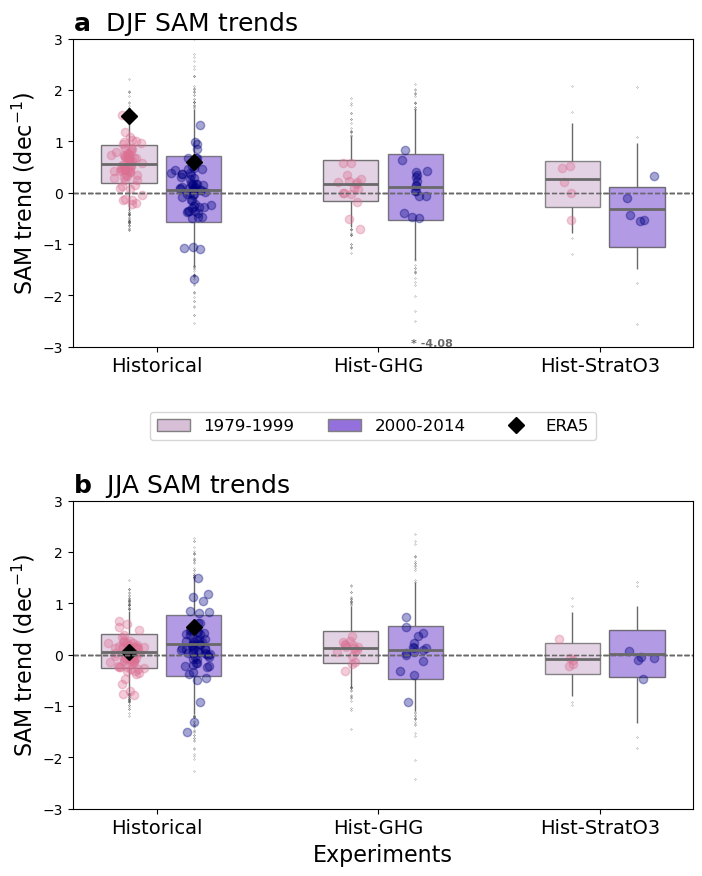

In [7]:
## PLOT
# DOTS = ENSEMBLE MEAN FOR EACH MODEL

datasets1_DJF = [trend_hist1_DJF, trend_ghg1_DJF, trend_o1_DJF]  # 1979-1999
datasets2_DJF = [trend_hist2_DJF, trend_ghg2_DJF, trend_o2_DJF]  # 2000-2014
datasets1_JJA = [trend_hist1_JJA, trend_ghg1_JJA, trend_o1_JJA]  # 1979-1999
datasets2_JJA = [trend_hist2_JJA, trend_ghg2_JJA, trend_o2_JJA]  # 2000-2014
obs_DJF = [trend_obs1_DJF, trend_obs2_DJF]
obs_JJA = [trend_obs1_JJA, trend_obs2_JJA]
labels = ["Historical", "Hist-GHG", "Hist-StratO3"]

fig, (ax31, ax32) = plt.subplots(2, 1, figsize=(8, 10))
box_palette = ['thistle', 'mediumpurple']  

def plot_season(ax, datasets1, datasets2, obs_data, season_label):
    width = 0.3  
    
    for i in range(len(labels)):
        data1 = datasets1[i].values.flatten() 
        data2 = datasets2[i].values.flatten() 
        
        model_means1 = datasets1[i].mean('runs', skipna=True)  # One value per model
        model_means2 = datasets2[i].mean('runs', skipna=True)
        
        # Adjusted positioning for better separation between scenarios
        base_pos = i * 1.2  
        pos1 = base_pos - width/2
        pos2 = base_pos + width/2 + 0.05  
        
        # Boxplot for 1979-1999 
        sns.boxplot(data=data1, positions=[pos1], whis=(5, 95), ax=ax,
                    showcaps=False, patch_artist=True, width=width,
                    boxprops=dict(facecolor=box_palette[0], alpha=0.7),
                    medianprops={'color': 'dimgrey', 'linewidth': 2},
                    whiskerprops={'color': 'dimgrey'},
                    flierprops=dict(marker='o', markersize=0.2, linestyle='none'))
        
        # Boxplot for 2000-2014 
        sns.boxplot(data=data2, positions=[pos2], whis=(5, 95), ax=ax,
                    showcaps=False, patch_artist=True, width=width,
                    boxprops=dict(facecolor=box_palette[1], alpha=0.7),
                    medianprops={'color': 'dimgrey', 'linewidth': 2},
                    whiskerprops={'color': 'dimgrey'},
                    flierprops=dict(marker='o', markersize=0.2, linestyle='none'))
        
        # Dots for individual models
        x_vals1 = np.random.normal(pos1, 0.04, size=len(model_means1))
        x_vals2 = np.random.normal(pos2, 0.04, size=len(model_means2))
        ax.plot(x_vals1, model_means1, 'o', color='palevioletred', alpha=0.35)
        ax.plot(x_vals2, model_means2, 'o', color='navy', alpha=0.35)
        
        # Add observation points 
        if i == 0:
            ax.plot([pos1], [obs_data[0]], 'D', color='k', markersize=8)  
            ax.plot([pos2], [obs_data[1]], 'D', color='k', markersize=8)  
    
        # Mmark extreme values beyond y-limits
        y_min, y_max = ax.get_ylim()  
        for i in range(len(labels)):  
            for j, dataset in enumerate([datasets1[i], datasets2[i]]):  
                data_values = dataset.values.flatten() 
                max_value = np.nanmax(data_values) 
                min_value = np.nanmin(data_values) 
                base_pos = i * 1.2  
                pos = base_pos - width/2 if j == 0 else base_pos + width/2 + 0.05  
                if max_value > y_max:
                    ax.annotate(f'{max_value:.2f}', 
                                xy=(pos, y_max), xycoords='data',
                                xytext=(pos, y_max - 0.2), textcoords='data', 
                                arrowprops=dict(arrowstyle='-|>', color='black', lw=1.5, mutation_scale=12),
                                fontsize=10, ha='center', va='top', color='black')
                if min_value < y_min:
                    pos1 = pos + 0.09
                    ax.text(pos1, y_min-0.22, f'* {min_value:.2f}', fontsize=8, ha='center', va='bottom', fontweight='bold', color='dimgrey')

        ax.axhline(0, color='dimgrey', linestyle='--', linewidth=1)
        ax.set_xticks([0, 1.2, 2.4])  
        ax.set_xticklabels(['Historical', 'Hist-GHG', 'Hist-StratO3'], fontsize=14)  
        ax.set_ylabel(r'SAM trend (dec$^{-1}$)', fontsize=16)


# Plot for DJF
plot_season(ax31, datasets1_DJF, datasets2_DJF, obs_DJF, 'DJF')
ax31.set_title(r'$\bf{a}$  DJF SAM trends', loc='left', fontsize=18)
ax31.set_ylim([-3,3])

# Plot for JJA
plot_season(ax32, datasets1_JJA, datasets2_JJA, obs_JJA, 'JJA')
ax32.set_title(r'$\bf{b}$  JJA SAM trends', loc='left', fontsize=18)
ax32.set_xlabel('Experiments', fontsize=16)
ax32.set_ylim([-3,3])

legend_elements = [Patch(facecolor='thistle', edgecolor='grey', label='1979-1999'),
                   Patch(facecolor='mediumpurple', edgecolor='grey', label='2000-2014'),
                   Line2D([0], [0], marker='D', color='k', label='ERA5', markersize=8, linestyle='None')]

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=[0.5, 0.47], fontsize=12, ncol=3)
plt.subplots_adjust(hspace=0.5)
#plt.savefig('Fig5_ab.pdf')

## 3) Fig. 5cd: SAM timeseries

In [21]:
from scipy.optimize import curve_fit

def piecewise_linear(x, x0, m1, b1, m2):
    """Piecewise linear function: Two segments meeting at x0."""
    return np.piecewise(x, 
                        [x < x0, x >= x0],
                        [lambda x: m1 * x + b1,  # First segment
                         lambda x: m2 * (x - x0) + (m1 * x0 + b1)])  # Second segment

def plot_piecewise_trend(ax, time, data, color):
    """Fit piecewise linear regression and plot it."""

    valid_mask = ~np.isnan(data)
    time = time.values.astype(float)  
    data = data.values  
    time, data = time[valid_mask], data[valid_mask]
    x0_init = 2000 
    # Fit the first segment (before the breakpoint)
    slope1, intercept1, _, _, _ = linregress(time[time < x0_init], data[time < x0_init])
    # Fit the second segment (after the breakpoint)
    slope2, intercept2, _, _, _ = linregress(time[time >= x0_init], data[time >= x0_init])
    p0 = [x0_init, slope1, intercept1, slope2] 
    # Fit the piecewise function with curve fitting
    params, _ = curve_fit(piecewise_linear, time, data, p0)
    x0, m1, b1, m2 = params
    trend = piecewise_linear(time, *params)
    # Plot the piecewise trend
    ax.plot(time, trend, color=color, linestyle='--', linewidth=2)

SAM_hist_DJF_models = SAM_hist_DJF.mean('runs', skipna=True)
SAM_GHG_DJF_models = SAM_GHG_DJF.mean('runs', skipna=True)
SAM_stratO3_DJF_models = SAM_stratO3_DJF.mean('runs', skipna=True)

SAM_hist_JJA_models = SAM_hist_JJA.mean('runs', skipna=True)
SAM_GHG_JJA_models = SAM_GHG_JJA.mean('runs', skipna=True)
SAM_stratO3_JJA_models = SAM_stratO3_JJA.mean('runs', skipna=True)

time_DJF = SAM_hist_DJF_models.time.dt.year
time_JJA = SAM_hist_JJA_models.time.dt.year
x_break = 2000

/jobfs/152294779.gadi-pbs/ipykernel_4149776/3634153373.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, time, data, p0)
/jobfs/152294779.gadi-pbs/ipykernel_4149776/3634153373.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(piecewise_linear, time, data, p0)


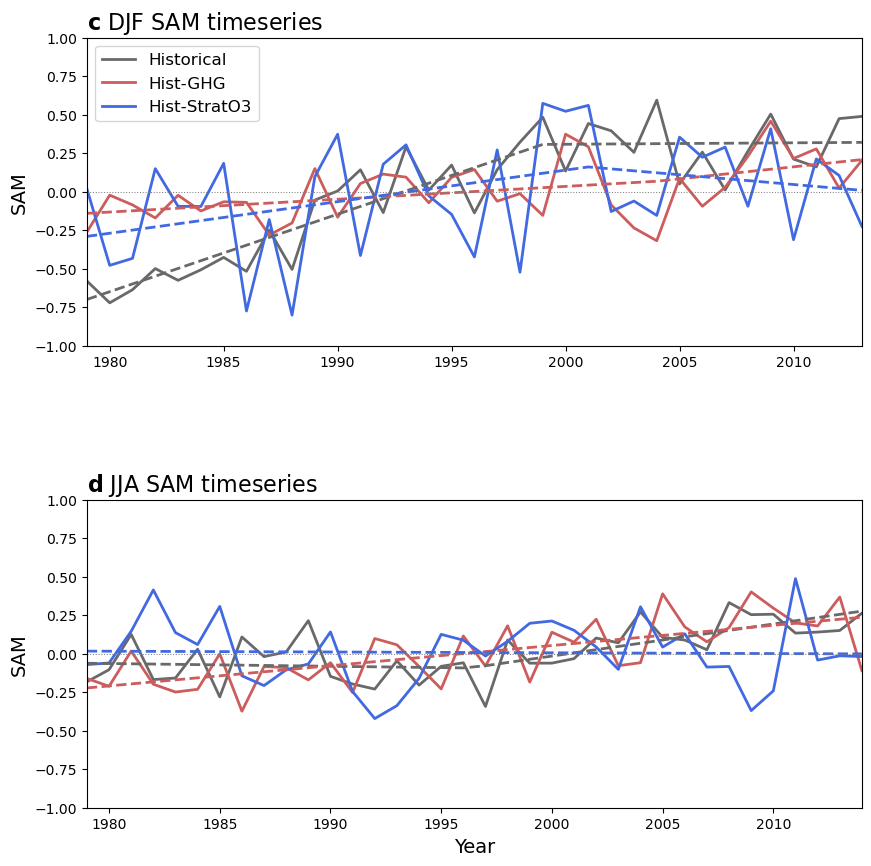

In [22]:
## PLOT

fig, (ax31, ax32) = plt.subplots(2, 1, figsize=(10, 10))

# Plot DJF
ax31.plot(time_DJF, SAM_hist_DJF_models.mean('models'), color='dimgrey', linewidth=2, label='Historical')
ax31.plot(time_DJF, SAM_GHG_DJF_models.mean('models'), color='indianred', linewidth=2, label='Hist-GHG')
ax31.plot(time_DJF, SAM_stratO3_DJF_models.mean('models'), color='royalblue', linewidth=2, label='Hist-StratO3')
plot_piecewise_trend(ax31, time_DJF, SAM_hist_DJF_models.mean('models'), 'dimgrey')
plot_piecewise_trend(ax31, time_DJF, SAM_GHG_DJF_models.mean('models'), 'indianred')
plot_piecewise_trend(ax31, time_DJF, SAM_stratO3_DJF_models.mean('models'), 'royalblue')
ax31.set_title(r'$\bf{c}$ DJF SAM timeseries', loc='left', fontsize=16)
ax31.set_ylabel('SAM', fontsize=14)
ax31.legend(loc='upper left', fontsize=12)
ax31.set_xlim([time_DJF[0], time_DJF[-1]])
ax31.set_ylim([-1, 1])
ax31.axhline(y=0, linewidth=0.75, linestyle=':', color='grey')

# Plot JJA
ax32.plot(time_JJA, SAM_hist_JJA_models.mean('models'), color='dimgrey', linewidth=2, label='Hist')
ax32.plot(time_JJA, SAM_GHG_JJA_models.mean('models'), color='indianred', linewidth=2, label='GHG')
ax32.plot(time_JJA, SAM_stratO3_JJA_models.mean('models'), color='royalblue',  linewidth=2, label='StratO3')
plot_piecewise_trend(ax32, time_JJA, SAM_hist_JJA_models.mean('models'), 'dimgrey')
plot_piecewise_trend(ax32, time_JJA, SAM_GHG_JJA_models.mean('models'), 'indianred')
plot_piecewise_trend(ax32, time_JJA, SAM_stratO3_JJA_models.mean('models'), 'royalblue')
ax32.set_title(r'$\bf{d}$ JJA SAM timeseries', loc='left', fontsize=16)
ax32.set_xlabel('Year', fontsize=14)
ax32.set_ylabel('SAM', fontsize=14)
ax32.set_xlim([time_JJA[0], time_JJA[-1]])
ax32.set_ylim([-1, 1])
ax32.axhline(y=0, linewidth=0.75, linestyle=':', color='grey')

plt.subplots_adjust(hspace=0.5)
#plt.savefig('/Fig5cd.pdf')
